# 3. TrainPredict_FineTune1
Kaggle score: 

Abstract:
- 在预测x_test的时候，在x_test数据添加augmentation的情况下，预测十次取最大值或平均。具体取最大值，还是取平均，多跑几次，看哪个成绩好。
- CNN模型中，input_tensor**不添加**crop。
- 官方提供的ImageGenerator的参数调整（对照组实验条件）
- image_size=299（对照组实验条件）

Tensorboard:
- Input at command: tensorboard --logdir=./log
- Input at browser: http://127.0.0.1:6006

Reference:
- https://www.kaggle.com/codename007/a-very-extensive-landmark-exploratory-analysis

## Run name

In [1]:
import time

project_name = 'ic_furniture2018'
step_name = 'TrainPredict_FineTune1'
time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime())
run_name = project_name + '_' + step_name + '_' + time_str
print('run_name: ' + run_name)
t0 = time.time()

run_name: ic_furniture2018_TrainPredict_FineTune1_20180520_192217


## Improtant Params

In [2]:
image_size = 299
width = height = image_size
target_size = (width, height)
batch_size = 32
epochs = 15
print(image_size)

299


## Import PKGs

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from IPython.display import display

import os
import gc
import math
import shutil
import zipfile
import pickle
import h5py
from PIL import Image

from tqdm import tqdm
from multiprocessing import cpu_count

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Project folders

In [4]:
cwd = os.getcwd()
input_folder = os.path.join(cwd, 'input')
output_folder = os.path.join(cwd, 'output')
model_folder = os.path.join(cwd, 'model')
feature_folder = os.path.join(cwd, 'feature')
post_pca_feature_folder = os.path.join(cwd, 'post_pca_feature')
log_folder = os.path.join(cwd, 'log')
print('input_folder: \t\t\t%s' % input_folder)
print('output_folder: \t\t\t%s' % output_folder)
print('model_folder: \t\t\t%s' % model_folder)
print('feature_folder: \t\t%s' % feature_folder)
print('post_pca_feature_folder: \t%s' % post_pca_feature_folder)
print('log_folder: \t\t\t%s' % log_folder)

org_train_folder = os.path.join(input_folder, 'org_train')
org_val_folder = os.path.join(input_folder, 'org_val')
org_test_folder = os.path.join(input_folder, 'org_test')
train_folder = os.path.join(input_folder, 'data_train')
val_folder = os.path.join(input_folder, 'data_val')
test_folder = os.path.join(input_folder, 'data_test')
test_sub_folder = os.path.join(test_folder, 'test')

if not os.path.exists(post_pca_feature_folder):
    os.mkdir(post_pca_feature_folder)
    print('Create folder: %s' % post_pca_feature_folder)

train_json_file = os.path.join(input_folder, 'train.json')
val_json_file = os.path.join(input_folder, 'validation.json')
test_json_file = os.path.join(input_folder, 'test.json')
print('\ntrain_json_file: \t\t%s' % train_json_file)
print('val_json_file: \t\t\t%s' % val_json_file)
print('test_json_file: \t\t%s' % test_json_file)

train_csv_file = os.path.join(input_folder, 'train.csv')
val_csv_file = os.path.join(input_folder, 'validation.csv')
test_csv_file = os.path.join(input_folder, 'test.csv')
print('\ntrain_csv_file: \t\t%s' % train_csv_file)
print('val_csv_file: \t\t\t%s' % val_csv_file)
print('test_csv_file: \t\t\t%s' % test_csv_file)

sample_submission_csv_file = os.path.join(input_folder, 'sample_submission_randomlabel.csv')
print('\nsample_submission_csv_file: \t%s' % sample_submission_csv_file)

input_folder: 			/data1/kaggle/imaterialist-challenge-furniture-2018/input
output_folder: 			/data1/kaggle/imaterialist-challenge-furniture-2018/output
model_folder: 			/data1/kaggle/imaterialist-challenge-furniture-2018/model
feature_folder: 		/data1/kaggle/imaterialist-challenge-furniture-2018/feature
post_pca_feature_folder: 	/data1/kaggle/imaterialist-challenge-furniture-2018/post_pca_feature
log_folder: 			/data1/kaggle/imaterialist-challenge-furniture-2018/log

train_json_file: 		/data1/kaggle/imaterialist-challenge-furniture-2018/input/train.json
val_json_file: 			/data1/kaggle/imaterialist-challenge-furniture-2018/input/validation.json
test_json_file: 		/data1/kaggle/imaterialist-challenge-furniture-2018/input/test.json

train_csv_file: 		/data1/kaggle/imaterialist-challenge-furniture-2018/input/train.csv
val_csv_file: 			/data1/kaggle/imaterialist-challenge-furniture-2018/input/validation.csv
test_csv_file: 			/data1/kaggle/imaterialist-challenge-furniture-2018/input/test.csv


## Preview data

In [5]:
train_csv = pd.read_csv(train_csv_file)
print('train_csv.shape is {0}.'.format(train_csv.shape))
display(train_csv.head(2))

val_csv = pd.read_csv(val_csv_file)
print('val_csv.shape is {0}.'.format(val_csv.shape))
display(val_csv.head(2))

test_csv = pd.read_csv(test_csv_file)
print('test_csv.shape is {0}.'.format(test_csv.shape))
display(test_csv.head(2))

test_csv = pd.read_csv(test_csv_file)
print('test_csv.shape is {0}.'.format(test_csv.shape))
display(test_csv.head(2))

sample_submission_csv = pd.read_csv(sample_submission_csv_file)
print('sample_submission_csv.shape is {0}.'.format(sample_submission_csv.shape))
display(sample_submission_csv.head(2))

train_csv.shape is (194828, 3).


,image_id,label_id,url
0,1,5,https://img13.360buyimg.com/imgzone/jfs/t2857/...
1,2,5,http://www.tengdakeli.cn/350/timg01/uploaded/i...


val_csv.shape is (6400, 3).


,image_id,label_id,url
0,1,38,http://www.ghs.net/public/images/fb/3d/51/3beb...
1,2,63,https://img.alicdn.com/imgextra/TB2chFei9YH8KJ...


test_csv.shape is (12800, 2).


,image_id,url
0,1,https://img13.360buyimg.com/imgzone/jfs/t13174...
1,2,http://img35.ddimg.cn/79/22/1258168705-1_u.jpg


test_csv.shape is (12800, 2).


,image_id,url
0,1,https://img13.360buyimg.com/imgzone/jfs/t13174...
1,2,http://img35.ddimg.cn/79/22/1258168705-1_u.jpg


sample_submission_csv.shape is (12800, 2).


,id,predicted
0,1,57
1,2,74


In [6]:
train_id = train_csv['image_id']
train_label_id = train_csv['label_id']

id_2_train_label_id_dict = dict(zip(train_id, train_label_id))
print('len(id_2_train_label_id_dict)=%d' % len(id_2_train_label_id_dict))

index = 0
print('id: %s, \tlandmark_id:%s' % (train_id[index], id_2_train_label_id_dict[train_id[index]]))
index = 1
print('id: %s, \tlandmark_id:%s' % (train_id[index], id_2_train_label_id_dict[train_id[index]]))

image_file = '%s_%s.jpg' % (train_id[index], id_2_train_label_id_dict[train_id[index]])
print(image_file)

len(id_2_train_label_id_dict)=194828
id: 1, 	landmark_id:5
id: 2, 	landmark_id:5
2_5.jpg


In [7]:
val_id = val_csv['image_id']
val_label_id = val_csv['label_id']

id_2_val_label_id_dict = dict(zip(val_id, val_label_id))
print('len(id_2_val_label_id_dict)=%d' % len(id_2_val_label_id_dict))

index = 0
print('id: %s, \tlandmark_id:%s' % (val_id[index], id_2_val_label_id_dict[val_id[index]]))
index = 1
print('id: %s, \tlandmark_id:%s' % (val_id[index], id_2_val_label_id_dict[val_id[index]]))

image_file = '%s_%s.jpg' % (val_id[index], id_2_val_label_id_dict[val_id[index]])
print(image_file)

len(id_2_val_label_id_dict)=6400
id: 1, 	landmark_id:38
id: 2, 	landmark_id:63
2_63.jpg


In [8]:
test_id = test_csv['image_id']

index = 0
print('id: %s' % (test_id[index]))
index = 1
print('id: %s' % (test_id[index]))

image_file = '%s.jpg' % (test_id[index])
print(image_file)

id: 1
id: 2
2.jpg


## Data Generator

In [9]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, TensorBoard, EarlyStopping

Using TensorFlow backend.


In [10]:
train_gen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
#     shear_range=50.,
    zoom_range=[0.85, 0.95],
#     channel_shift_range=100.,
    fill_mode='wrap',
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.9, 1.]
)

val_gen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
#     shear_range=50.,
    zoom_range=[0.85, 0.95],
#     channel_shift_range=100.,
    fill_mode='wrap',
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.9, 1.]
)

test_gen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
#     shear_range=50.,
    zoom_range=[0.85, 0.95],
#     channel_shift_range=100.,
    fill_mode='wrap',
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.9, 1.]
)

In [11]:
data_train_path = os.path.join(input_folder, 'data_train')
data_val_path = os.path.join(input_folder, 'data_val')
data_test_path = os.path.join(input_folder, 'data_test')

In [12]:
%%time
def dump_pickle_generator(run_name, test_gen, model_folder=model_folder):
    test_gen_file = os.path.join(model_folder, 'test_gen_%s.pickle' % run_name)
    print('Dump: ', test_gen_file)
    pickle.dump(test_gen, open(test_gen_file, "wb"), True)

def load_pickle_generator(run_name, model_folder=model_folder):
    test_gen_file = os.path.join(model_folder, 'test_gen_%s.pickle' % run_name)
    test_gen = pickle.load(open(test_gen_file, "rb"))
    print('Load: ', test_gen_file)
    return test_gen

dump_pickle_generator(run_name, test_gen)
test_gen = load_pickle_generator(run_name)

Dump:  /data1/kaggle/imaterialist-challenge-furniture-2018/model/test_gen_ic_furniture2018_TrainPredict_FineTune1_20180520_192217.pickle
Load:  /data1/kaggle/imaterialist-challenge-furniture-2018/model/test_gen_ic_furniture2018_TrainPredict_FineTune1_20180520_192217.pickle
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 715 µs


In [13]:
train_generator = train_gen.flow_from_directory(data_train_path, target_size, shuffle=True, batch_size=batch_size)
val_generator = val_gen.flow_from_directory(data_val_path, target_size, shuffle=False, batch_size=batch_size)
test_generator = test_gen.flow_from_directory(data_test_path, target_size, shuffle=False, batch_size=batch_size)

Found 249833 images belonging to 128 classes.
Found 6301 images belonging to 128 classes.
Found 12652 images belonging to 1 classes.


In [14]:
print(train_generator.classes[:10])
print(val_generator.classes[:10])
print(test_generator.classes[:10])

print(test_generator.filenames[:10])

[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
['test/1.jpg', 'test/10.jpg', 'test/100.jpg', 'test/1000.jpg', 'test/10000.jpg', 'test/10001.jpg', 'test/10002.jpg', 'test/10003.jpg', 'test/10004.jpg', 'test/10005.jpg']


In [15]:
steps_per_epoch_train = int(len(train_generator.classes) / batch_size)
steps_per_epoch_val = int(len(val_generator.classes) / batch_size)
print('steps_per_epoch_train=%s' % steps_per_epoch_train)
print('steps_per_epoch_val=%s' % steps_per_epoch_val)

steps_per_epoch_train=7807
steps_per_epoch_val=196


## Build NN

In [16]:
from sklearn.metrics import confusion_matrix

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.applications import *

In [17]:
%%time

input_tensor = Input((height, width, 3))
# input_tensor_preprocess = Cropping2D(cropping=((20, 20), (20, 20)))(input_tensor)
input_tensor_preprocess = Lambda(inception_resnet_v2.preprocess_input)(input_tensor)
base_model = InceptionResNetV2(input_tensor=input_tensor_preprocess, weights='imagenet', include_top=False)
x = GlobalAveragePooling2D()(base_model.output)

x = Dropout(0.2)(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(2048, activation='relu')(x)
x = Dense(128, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=x)

for layer in base_model.layers:
    layer.trainable = True

CPU times: user 35.7 s, sys: 0 ns, total: 35.7 s
Wall time: 35.3 s


In [18]:
%%time
model.compile(
    optimizer=Adam(lr=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 299, 299, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         lambda_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

activation_165 (Activation)     (None, 8, 8, 192)    0           batch_normalization_165[0][0]    
__________________________________________________________________________________________________
conv2d_166 (Conv2D)             (None, 8, 8, 224)    129024      activation_165[0][0]             
__________________________________________________________________________________________________
batch_normalization_166 (BatchN (None, 8, 8, 224)    672         conv2d_166[0][0]                 
__________________________________________________________________________________________________
activation_166 (Activation)     (None, 8, 8, 224)    0           batch_normalization_166[0][0]    
__________________________________________________________________________________________________
conv2d_164 (Conv2D)             (None, 8, 8, 192)    399360      mixed_7a[0][0]                   
__________________________________________________________________________________________________
conv2d_167

__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 1536)         0           conv_7b_ac[0][0]                 
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 1536)         0           global_average_pooling2d_1[0][0] 
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2048)         3147776     dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 2048)         0           dense_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2048)         4196352     dropout_2[0][0]                  
__________

In [19]:
def get_lr(x):
    lr = round(3e-4 * 0.9 ** x, 6)
    if lr < 1e-5:
        lr = 1e-5
    
#     if x <= 5:
#         lr = 3e-4
#     elif x > 5 and x <= 14:
#         lr = 1e-4
#     elif x > 14 and x <= 20:
#         lr = 3e-5
#     elif x > 20 and x <= 25:
#         lr = 3e-5
#     else:
#         lr = 1e-5
    print(lr, end='  ')
    return lr

for i in range(1, epochs + 1):
    get_lr(i)
    print(i)
# annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
annealer = LearningRateScheduler(get_lr)

early_stop = EarlyStopping(monitor='val_acc', min_delta=0.003, patience=0.002, verbose=0, mode='auto')

log_dir = os.path.join(log_folder, run_name)
print('\nlog_dir: %s' % log_dir)
tensorBoard = TensorBoard(log_dir=log_dir)


callbacks = []
callbacks = [annealer]
# callbacks = [annealer]

0.00027  1
0.000243  2
0.000219  3
0.000197  4
0.000177  5
0.000159  6
0.000143  7
0.000129  8
0.000116  9
0.000105  10
9.4e-05  11
8.5e-05  12
7.6e-05  13
6.9e-05  14
6.2e-05  15

log_dir: /data1/kaggle/imaterialist-challenge-furniture-2018/log/ic_furniture2018_TrainPredict_FineTune1_20180520_192217


In [20]:
cpu_amount = cpu_count()
print(cpu_amount)

8


In [21]:
%%time
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch_train,
    epochs=epochs, #Increase this when not on Kaggle kernel
    verbose=1,  #1 for ETA, 0 for silent
    callbacks=callbacks,
    max_queue_size=batch_size,
    workers=cpu_amount,
    use_multiprocessing=True,
    validation_data=val_generator,
    validation_steps=steps_per_epoch_val
)

7807/7807 [==============================] - 3903s 500ms/step - loss: 1.2199 - acc: 0.6574 - val_loss: 1.0277 - val_acc: 0.7023
Epoch 2/15
7807/7807 [==============================] - 3832s 491ms/step - loss: 0.7552 - acc: 0.7737 - val_loss: 0.8867 - val_acc: 0.7502
Epoch 3/15
7807/7807 [==============================] - 3837s 491ms/step - loss: 0.6034 - acc: 0.8139 - val_loss: 0.9543 - val_acc: 0.7664
Epoch 4/15
7807/7807 [==============================] - 3847s 493ms/step - loss: 0.4975 - acc: 0.8426 - val_loss: 0.7501 - val_acc: 0.7870
Epoch 5/15
6756/7807 [========================>.....] - ETA: 8:43 - loss: 0.4163 - acc: 0.8658

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3586/7807 [============>.................] - ETA: 35:05 - loss: 0.3480 - acc: 0.8857

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



7807/7807 [==============================] - 3956s 507ms/step - loss: 0.3493 - acc: 0.8849 - val_loss: 0.6974 - val_acc: 0.8149
Epoch 7/15
 337/7807 [>.............................] - ETA: 1:04:00 - loss: 0.2875 - acc: 0.9046

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4981/7807 [==================>...........] - ETA: 23:43 - loss: 0.2927 - acc: 0.9024

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3674/7807 [=============>................] - ETA: 34:41 - loss: 0.2439 - acc: 0.9176

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



7807/7807 [==============================] - 4062s 520ms/step - loss: 0.2478 - acc: 0.9168 - val_loss: 0.6770 - val_acc: 0.8208
Epoch 9/15
7807/7807 [==============================] - 4166s 534ms/step - loss: 0.2076 - acc: 0.9294 - val_loss: 0.7040 - val_acc: 0.8327
Epoch 10/15
4782/7807 [=================>............] - ETA: 26:57 - loss: 0.1739 - acc: 0.9401

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



7807/7807 [==============================] - 4405s 564ms/step - loss: 0.1516 - acc: 0.9483 - val_loss: 0.7446 - val_acc: 0.8281
Epoch 12/15
7807/7807 [==============================] - 4456s 571ms/step - loss: 0.1274 - acc: 0.9571 - val_loss: 0.7850 - val_acc: 0.8347
Epoch 13/15
7807/7807 [==============================] - 4453s 570ms/step - loss: 0.1094 - acc: 0.9631 - val_loss: 0.8372 - val_acc: 0.8300
Epoch 14/15
7807/7807 [==============================] - 4427s 567ms/step - loss: 0.0944 - acc: 0.9678 - val_loss: 0.8668 - val_acc: 0.8350
Epoch 15/15
7807/7807 [==============================] - 4420s 566ms/step - loss: 0.0827 - acc: 0.9724 - val_loss: 0.8967 - val_acc: 0.8313
CPU times: user 17h 18min 53s, sys: 8h 57min 44s, total: 1d 2h 16min 38s
Wall time: 17h 15min 25s


In [22]:
%%time
final_loss, final_acc = model.evaluate_generator(
    val_generator,
    max_queue_size=batch_size,
    workers=cpu_amount,
    use_multiprocessing=True,
    steps=steps_per_epoch_val
)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

Final loss: 0.8903, final accuracy: 0.8331
CPU times: user 23.3 s, sys: 17 s, total: 40.4 s
Wall time: 1min 1s


In [23]:
run_name_acc = run_name + '_' + str(int(final_acc*10000)).zfill(4)
print(run_name_acc)

ic_furniture2018_TrainPredict_FineTune1_20180520_192217_8330


In [24]:
histories = pd.DataFrame(hist.history)
histories['epoch'] = hist.epoch
print(histories.columns)
histories_file = os.path.join(model_folder, run_name_acc + '.csv')
histories.to_csv(histories_file, index=False)

Index(['acc', 'loss', 'val_acc', 'val_loss', 'epoch'], dtype='object')


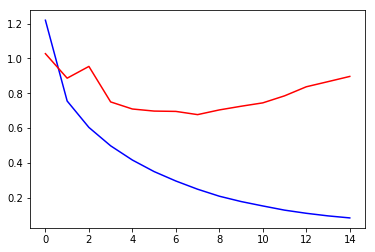

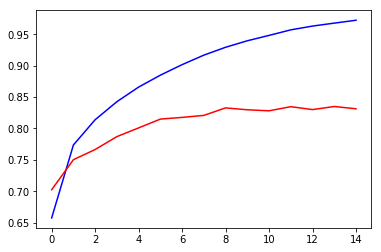

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

In [26]:
def save_network(model, run_name):
    cwd = os.getcwd()
    modelPath = os.path.join(cwd, 'model')
    if not os.path.isdir(modelPath):
        os.mkdir(modelPath)
    weigthsFile = os.path.join(modelPath, run_name + '.h5')
    model.save(weigthsFile)
save_network(model, run_name_acc)

### Change Optimizer

In [27]:
# model.compile(
#     optimizer='sgd',
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

# callbacks = []

In [28]:
# %%time
# hist = model.fit_generator(train_generator,
#     steps_per_epoch=steps_per_epoch_train,
#     epochs=10, #Increase this when not on Kaggle kernel
#     verbose=1,  #1 for ETA, 0 for silent
#     callbacks=callbacks,
#     max_queue_size=batch_size,
#     workers=cpu_amount,
#     use_multiprocessing=False,
#     validation_data=val_generator,
#     validation_steps=steps_per_epoch_val)

In [29]:
# %%time
# final_loss, final_acc = model.evaluate_generator(
#     val_generator,
#     max_queue_size=batch_size,
#     workers=cpu_amount,
#     use_multiprocessing=False,
#     steps=steps_per_epoch_val
# )
# print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

In [30]:
# run_name_acc = run_name + '_' + str(int(final_acc*10000)).zfill(4)
# print(run_name_acc)

In [31]:
# histories = pd.DataFrame(hist.history)
# histories['epoch'] = hist.epoch
# print(histories.columns)
# histories_file = os.path.join(model_folder, run_name_acc + '.csv')
# histories.to_csv(histories_file, index=False)

In [32]:
# import matplotlib.pyplot as plt
# %matplotlib inline

# plt.plot(hist.history['loss'], color='b')
# plt.plot(hist.history['val_loss'], color='r')
# plt.show()
# plt.plot(hist.history['acc'], color='b')
# plt.plot(hist.history['val_acc'], color='r')
# plt.show()

In [33]:
# def save_network(model, run_name):
#     cwd = os.getcwd()
#     modelPath = os.path.join(cwd, 'model')
#     if not os.path.isdir(modelPath):
#         os.mkdir(modelPath)
#     weigthsFile = os.path.join(modelPath, run_name + '.h5')
#     model.save(weigthsFile)
# save_network(model, run_name_acc)

## Predict

In [34]:
from sklearn.metrics import accuracy_score

In [35]:
train_generator = train_gen.flow_from_directory(data_train_path, target_size, shuffle=False, batch_size=batch_size)
train_generator.classes[:10]

Found 249833 images belonging to 128 classes.


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [36]:
%%time
y_train_proba = model.predict_generator(
    train_generator,
    max_queue_size=128,
    workers=cpu_amount,
    use_multiprocessing=True
)
print(y_train_proba.shape)

(249833, 128)
CPU times: user 13min 17s, sys: 48min 27s, total: 1h 1min 45s
Wall time: 50min 53s


In [37]:
%%time
y_val_proba = model.predict_generator(
    val_generator,
    max_queue_size=128,
    workers=cpu_amount,
    use_multiprocessing=True
)
print(y_val_proba.shape)
y_val_pred = np.argmax(y_val_proba, -1)
acc_val = accuracy_score(val_generator.classes, y_val_pred)
print('max acc_val: %.4f' % acc_val)

(6301, 128)
max acc_val: 0.8305
CPU times: user 22 s, sys: 37.8 s, total: 59.8 s
Wall time: 1min 10s


In [38]:
def predict_generator(model, generator, epoch=10):
    print('|', end='')
    y_data_probas = []
    for i in range(epoch):
        print('*', end='')
        y_data_proba_temp = model.predict_generator(
            generator,
            max_queue_size=128,
            workers=cpu_amount,
            use_multiprocessing=True
        )
        y_data_proba_temp = y_data_proba_temp[:,:,np.newaxis]
        y_data_probas.append(y_data_proba_temp)
    print('|')
    y_data_probas = np.concatenate(y_data_probas, axis=-1)
    return y_data_probas

In [39]:
y_val_probas = predict_generator(model, val_generator, 10)
print(y_val_probas.shape)

y_val_proba = np.mean(y_val_probas, axis=-1)
y_val_pred = np.argmax(y_val_proba, -1)
acc_val = accuracy_score(val_generator.classes, y_val_pred)
print('mean acc_val: %.4f' % acc_val)

y_val_proba = np.max(y_val_probas, axis=-1)
y_val_pred = np.argmax(y_val_proba, -1)
acc_val = accuracy_score(val_generator.classes, y_val_pred)
print('max acc_val: %.4f' % acc_val)

|**********|
(6301, 128, 10)
mean acc_val: 0.8335
max acc_val: 0.8342


In [40]:
%%time
y_test_probas = predict_generator(model, test_generator, 10)
y_test_proba = np.max(y_test_probas, axis=-1)
print(y_test_proba.shape)

|**********|
(12652, 128)
CPU times: user 7min 3s, sys: 14min 9s, total: 21min 12s
Wall time: 25min 58s


In [41]:
# 这里证明os.listdir()得到的图片名称list不正确
files = os.listdir(os.path.join(test_folder, 'test'))
print(files[:10])

# 这里证明ImageDataGenerator()得到的图片名称list才是正确
# gen = ImageDataGenerator()
# image_size = (299, 299)
# test_generator  = gen.flow_from_directory(test_folder, image_size, shuffle=False, batch_size=batch_size)
print('test_generator')
print(len(test_generator.filenames))
print(test_generator.filenames[:10])

['7349.jpg', '8809.jpg', '6409.jpg', '5631.jpg', '9579.jpg', '7198.jpg', '6107.jpg', '10190.jpg', '5354.jpg', '10962.jpg']
test_generator
12652
['test/1.jpg', 'test/10.jpg', 'test/100.jpg', 'test/1000.jpg', 'test/10000.jpg', 'test/10001.jpg', 'test/10002.jpg', 'test/10003.jpg', 'test/10004.jpg', 'test/10005.jpg']


In [42]:
def save_proba(y_train_proba, y_train, y_val_proba, y_val, y_test_proba, test_filenames, file_name):
    test_filenames = [n.encode('utf8') for n in test_filenames]
    print(test_filenames[:10])
    if os.path.exists(file_name):
        os.remove(file_name)
        print('File removed: \t%s' % file_name)
    with h5py.File(file_name) as h:
        h.create_dataset('y_train_proba', data=y_train_proba)
        h.create_dataset('y_train', data=y_train)
        h.create_dataset('y_val_proba', data=y_val_proba)
        h.create_dataset('y_val', data=y_val)
        h.create_dataset('y_test_proba', data=y_test_proba)
        h.create_dataset('test_filenames', data=test_filenames)
    print('File saved: \t%s' % file_name)

def load_proba(file_name):
    with h5py.File(file_name, 'r') as h:
        y_train_proba = np.array(h['y_train_proba'])
        y_train = np.array(h['y_train'])
        y_val_proba = np.array(h['y_val_proba'])
        y_val = np.array(h['y_val'])
        y_test_proba = np.array(h['y_test_proba'])
        test_filenames = np.array(h['test_filenames'])
    print('File loaded: \t%s' % file_name)
    test_filenames = [n.decode('utf8') for n in test_filenames]
    print(test_filenames[:10])
    
    return y_train_proba, y_train, y_val_proba, y_val, y_test_proba, test_filenames


y_proba_file = os.path.join(model_folder, 'proba_%s.p' % run_name_acc)
save_proba(y_train_proba, train_generator.classes, y_val_proba, val_generator.classes, y_test_proba, test_generator.filenames, y_proba_file)
y_train_proba, y_train, y_val_proba, y_val, y_test_proba, test_filenames = load_proba(y_proba_file)

print(y_train_proba.shape)
print(y_train.shape)
print(y_val_proba.shape)
print(y_val.shape)
print(y_test_proba.shape)
print(len(test_filenames))

[b'test/1.jpg', b'test/10.jpg', b'test/100.jpg', b'test/1000.jpg', b'test/10000.jpg', b'test/10001.jpg', b'test/10002.jpg', b'test/10003.jpg', b'test/10004.jpg', b'test/10005.jpg']
File saved: 	/data1/kaggle/imaterialist-challenge-furniture-2018/model/proba_ic_furniture2018_TrainPredict_FineTune1_20180520_192217_8330.p
File loaded: 	/data1/kaggle/imaterialist-challenge-furniture-2018/model/proba_ic_furniture2018_TrainPredict_FineTune1_20180520_192217_8330.p
['test/1.jpg', 'test/10.jpg', 'test/100.jpg', 'test/1000.jpg', 'test/10000.jpg', 'test/10001.jpg', 'test/10002.jpg', 'test/10003.jpg', 'test/10004.jpg', 'test/10005.jpg']
(249833, 128)
(249833,)
(6301, 128)
(6301,)
(12652, 128)
12652


In [43]:
%%time
max_indexes = np.argmax(y_test_proba, -1)
print(max_indexes.shape)

test_dict = {}
for pair in zip(test_generator.filenames, max_indexes):
    image_name, indx = pair[0], int(pair[1])
    image_name = image_name.split('/')[-1]
    image_id = int(image_name.split('.')[0])
#     print(pair[0], image_name, image_id, indx, indx+1, type(image_id), type(indx))
    test_dict[image_id] = indx + 1

#确认图片的id是否能与ImageDataGenerator()对应上
for name in test_generator.filenames[:10]:
    image_name = name.split('/')[-1]
    image_id = int(image_name.split('.')[0])
#     print('%s\t%s\t%s' % (name, image_id, test_dict[image_id]))

(12652,)
CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 21.2 ms


In [44]:
display(sample_submission_csv.head(2))

,id,predicted
0,1,57
1,2,74


In [45]:
%%time
len_sample_submission_csv = len(sample_submission_csv)
print('len(len_sample_submission_csv)=%d' % len_sample_submission_csv)
count = 0
for i in range(len_sample_submission_csv):
    image_id = int(sample_submission_csv.iloc[i, 0])
    if image_id in test_dict:
        pred_label = test_dict[image_id]
#         print('%s\t%s' % (image_id, pred_label))
        sample_submission_csv.iloc[i, 1] = pred_label
    else:
#         print('%s\t%s' % (image_id, 20))
        sample_submission_csv.iloc[i, 1] = 20 # 属于20的类最多，所以全都设置成这个类，可能会比设置成其他得到的结果好
    count += 1
    if count % 1000 == 0:
        print(int(count/1000), end=' ')
display(sample_submission_csv.head(2))

len(len_sample_submission_csv)=12800
1 2 3 4 5 6 7 8 9 10 11 12 

,id,predicted
0,1,12
1,2,71


CPU times: user 11.9 s, sys: 1 s, total: 12.9 s
Wall time: 12.9 s


In [46]:
print(list(set(sample_submission_csv['predicted'])))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128]


In [47]:
pred_file = os.path.join(output_folder, 'pred_' + run_name_acc + '.csv')
sample_submission_csv.to_csv(pred_file, index=None)

In [48]:
print(run_name_acc)

t1 = time.time()
print('time cost: %.2f s' % (t1-t0))
print('Done!')

ic_furniture2018_TrainPredict_FineTune1_20180520_192217_8330
time cost: 68065.62 s
Done!
